In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dropout, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

import os
import numpy as np 

from skimage.io import imread, imshow
import matplotlib.pyplot as plt
from tqdm import tqdm 

In [ ]:
# read and write images using tifffile 

In [ ]:
# check gpus
print("n GPUs available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.is_gpu_available(), 
      tf.test.gpu_device_name())
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [2]:
# prepare to load data
path = os.getcwd()
raw_path = path+'/raw/'
skeletonised_path = path+'/skeletonised/'

raw_ids = next(os.walk(raw_path))[2]
skeletonised_ids = next(os.walk(skeletonised_path))[2]

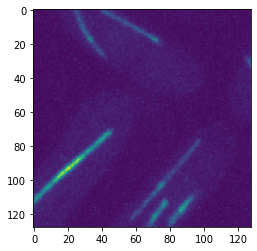

In [3]:
im = imread(raw_path+"/"+raw_ids[0])
plt.imshow(im);

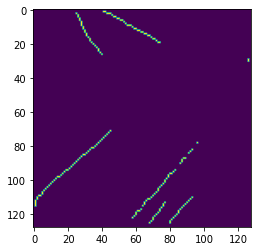

In [4]:
im = imread(skeletonised_path+"/"+skeletonised_ids[0])
plt.imshow(im);

In [6]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 1

In [10]:
x_train = np.zeros((len(raw_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint16)
y_train = np.zeros((len(skeletonised_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

In [11]:
for i in range(len(raw_ids)):
    x_train[i] = np.expand_dims(imread(raw_path+"/"+raw_ids[i]), -1)
    y_train[i] = np.expand_dims(imread(skeletonised_path+"/"+skeletonised_ids[i]), -1)

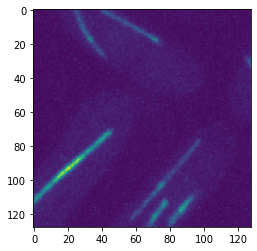

In [9]:
plt.imshow(x_train[0]);

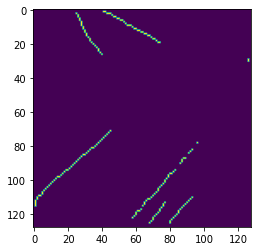

In [12]:
plt.imshow(y_train[0]);

In [17]:
# train test split 
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.25)

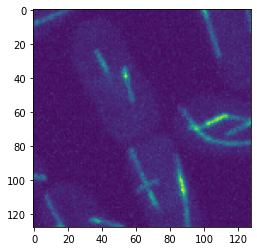

In [19]:
import random 
n = int(random.random())
plt.imshow(X_train[n]);

In [20]:
# define model 
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

# encoding branch
conv1 = Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
conv1 = Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2,2), padding='same')(conv1)
drop1 = Dropout(0.25)(pool1) ## dropout rate = one of hyperparameters to tune 

conv2 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(drop1)
conv2 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
drop2 = Dropout(0.25)(pool2)

conv3 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(drop2)
conv3 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
drop3 = Dropout(0.25)(pool3)

conv4 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(drop3)
conv4 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
pool4 = MaxPooling2D(pool_size=(2,2))(conv4)
drop4 = Dropout(0.25)(pool4)

conv5 = Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(drop4)
conv5 = Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
#drop5 = Dropout(0.25)(conv5) ## make sure to change up6

# decoding / upscaling (transpose convolution)
up6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same', kernel_initializer='he_normal')(conv5)
concat6 = concatenate([up6, conv4], axis=3)
conv6 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(concat6)
conv6 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
drop6 = Dropout(0.25)(conv6)

up7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same', kernel_initializer='he_normal')(drop6)
concat7 = concatenate([up7, conv3], axis=3)
conv7 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(concat7)
conv7 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
drop7 = Dropout(0.25)(conv7)

up8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same', kernel_initializer='he_normal')(drop7)
concat8 = concatenate([up8, conv2], axis=3)
conv8 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(concat8)
conv8 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
drop8 = Dropout(0.25)(conv8)
                      
up9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding='same', kernel_initializer='he_normal')(drop8)
concat9 = concatenate([up9, conv1], axis=3)
conv9 = Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(concat9)
conv9 = Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
drop9 = Dropout(0.25)(conv9)

outputs = Conv2D(2, (1,1), activation='softmax')(drop9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
# check if model corresponds to expectation
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 16)   0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [22]:
results = model.fit(x=X_train, y=y_train, validation_split=0.1, batch_size=8, epochs=3)

Epoch 1/3
3/3 [==============================] - 2s 729ms/step - loss: 7.4692 - accuracy: 0.7315 - val_loss: 7.5666 - val_accuracy: 0.9766
Epoch 2/3
3/3 [==============================] - 1s 399ms/step - loss: 7.4519 - accuracy: 0.7174 - val_loss: 7.5747 - val_accuracy: 0.9783
Epoch 3/3
3/3 [==============================] - 1s 418ms/step - loss: 7.4337 - accuracy: 0.7049 - val_loss: 7.5816 - val_accuracy: 0.9796
